# Detecting BDM In Superbowl Commercials

In [523]:
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()

True

In [524]:

BDM_excel= pd.read_excel(f"{os.getenv("BDM_EXCEL_FILE")}")
final_excel = pd.read_excel(f"{os.getenv("FINAL_EXCEL_FILE")}")


In [525]:
final_excel = final_excel.merge(
    BDM_excel[['AdNumber', 'BDM']], 
    on='AdNumber', 
    how='left',
    suffixes=('_old', '')
).drop('BDM_old', axis=1, errors='ignore')


# print number of rows where BDM is NaN, 0 and 1
print(f"Number of rows where BDM is NaN: {final_excel[final_excel['BDM'].isna()].shape[0]}")
print(f"Number of rows where BDM is 0: {final_excel[final_excel['BDM'] == 0].shape[0]}")
print(f"Number of rows where BDM is 1: {final_excel[final_excel['BDM'] == 1].shape[0]}")


Number of rows where BDM is NaN: 22
Number of rows where BDM is 0: 411
Number of rows where BDM is 1: 139


In [526]:
ad_df = final_excel.groupby(['cont_primary_product_type', 'BRAND', 'AdNumber', "BDM"]).size().reset_index(name='count')
ad_df.rename(columns={'cont_primary_product_type': 'product_category', 'BRAND': 'brand', 'AdNumber': 'commercial_number'}, inplace=True)
ad_df.drop(columns=['count'], inplace=True)
ad_df.head(10)

,product_category,brand,commercial_number,BDM
0,1.0,AvocadosfromMexico,AD0357,0.0
1,1.0,AvocadosfromMexico,AD0414,1.0
2,1.0,AvocadosfromMexico,AD0474,0.0
3,1.0,AvocadosfromMexico,AD0525,1.0
4,1.0,AvocadosfromMexico,AD0584,1.0
5,1.0,AvocadosfromMexico,AD0635,1.0
6,1.0,AvocadosfromMexico,AD0745,0.0
7,1.0,BUBLY,AD0586,1.0
8,1.0,Bai,AD0475,0.0
9,1.0,Butterfinger,AD0420,1.0


## Retrieving Transcript

In [527]:
import glob
from pathlib import Path

# Get all txt files recursively from ADS_DIR
ads_dir = Path(os.getenv("ADS_DIR"))
transcript_files = glob.glob(str(ads_dir / "**/*.txt"), recursive=True)
# print transcript_files
print(transcript_files)
# Create a dictionary mapping commercial numbers to file paths
transcript_map = {Path(f).stem: f for f in transcript_files}

# Update transcripts in dataframe
ad_df['transcript'] = ''
for idx, row in ad_df.iterrows():
    commercial_num = row['commercial_number']
    if commercial_num in transcript_map:
        try:
            with open(transcript_map[commercial_num], 'r', encoding='utf-8') as f:
                ad_df.at[idx, 'transcript'] = f.read().strip()
        except FileNotFoundError:
            ad_df.at[idx, 'transcript'] = None
    else:
        ad_df.at[idx, 'transcript'] = None

ad_df[ad_df['transcript'].notna()]
ad_df.head(10)

['/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0380.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0408.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0399.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0359.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0383.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0393.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0370.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0377.txt', '/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/ADs/ADs_IG_2015/AD0404.txt', '/home/arkastor/Development/Commerci

,product_category,brand,commercial_number,BDM,transcript
0,1.0,AvocadosfromMexico,AD0357,0.0,"With the next pick in the first draft ever, Au..."
1,1.0,AvocadosfromMexico,AD0414,1.0,Over here we have the cube of Rubik. This simp...
2,1.0,AvocadosfromMexico,AD0474,0.0,"Guys, how can we be a secret society if we can..."
3,1.0,AvocadosfromMexico,AD0525,1.0,"Well, we did it. We sealed the bad out and kep..."
4,1.0,AvocadosfromMexico,AD0584,1.0,"Pageantry, poise, welcome to the dog show wher..."
5,1.0,AvocadosfromMexico,AD0635,1.0,Welcome to the Avocados from Mexico shopping n...
6,1.0,AvocadosfromMexico,AD0745,0.0,This is officially the worst tailgate I've eve...
7,1.0,BUBLY,AD0586,1.0,"Ooh, Blackberry Bublé, my favorite. You mean B..."
8,1.0,Bai,AD0475,0.0,I don't want to make it tough. I just want to ...
9,1.0,Butterfinger,AD0420,1.0,"A bull rider is bold. Now, a bull rider on a p..."


# Removing Musical Lyrics from transcript

<div class="alert alert-block alert-warning">
<b>NEU:</b>
Entfernen von lyrics leider nicht möglich
Es ist so ziemlich unmöglich Lyrics von dem Transkript zu entfernen

Tools wie z.b. `Librosa` oder`spleeter` können zwar instrumentals von gesang trennen aber es gibt (nicht mal im Ansatz) keine tools die lyrics von normalem Text unterscheiden.

Man könnte zwar wahrscheinlich alle stellen von der audio datei entfernen wo gerade musik gespielt wird. Allerdings würde dies auch instrumentals einschließen und damit auch sehr viele Teile des "normalen" Transkripts entfernen
</div>

In [528]:
ad_df[ad_df['transcript'].str.contains('🎵', na=False)]
# print each row where the transcript contains 🎵


,product_category,brand,commercial_number,BDM,transcript
16,1.0,CocaCola,AD0265,0.0,🎵
17,1.0,CocaCola,AD0316,0.0,🎵 🎵 Oh beautiful for spacious skies 🎵 🎵 Por tu...
21,1.0,CocaCola,AD0480,0.0,🎵
44,1.0,Heinz,AD0649,0.0,🎵 🎵 I'll be there 🎵 🎵 With a love that will sh...
70,1.0,Pepsi,AD0446,0.0,🎵
138,2.0,MichelobULTRA,AD0604,1.0,🎵
332,10.0,Gildan,AD0270,0.0,🎵
470,21.0,TMobile,AD0623,0.0,🎵
500,25.0,Airbnb,AD0467,0.0,🎵


## Adding OCR Text

<div class="alert alert-block alert-success">
<b>NEU:</b>
OCR Ergebnisse an das Transkript appended
</div>

In [529]:

ocr_to_merge = pd.read_csv("./ocr_to_merge.csv")
ad_df = ad_df.merge(ocr_to_merge, left_on='commercial_number', right_on='ad', how='left')
ad_df.drop(columns=['ad', 'recognized_text'], inplace=True)
ad_df.rename(columns={'cleaned_text': 'ocr_text'}, inplace=True)

# merge ocr_text with transcript
# TODO: Rename transcript to transcript_plus_ocr
ad_df['transcript'] = ad_df['ocr_text'] + ' ' + ad_df['transcript']
ad_df.drop(columns=['ocr_text'], inplace=True)

ad_df.head()


,product_category,brand,commercial_number,BDM,transcript
0,1.0,AvocadosfromMexico,AD0357,0.0,FIRST DRAFT EVER DRAFT SLOTH DODO BIRD FIRE PO...
1,1.0,AvocadosfromMexico,AD0414,1.0,I Avocados Mexico ALWAYS IN SEASON Over here w...
2,1.0,AvocadosfromMexico,AD0474,0.0,"HEALTHY Avocados Mexico ALWAYS IN SEASON Guys,..."
3,1.0,AvocadosfromMexico,AD0525,1.0,Chris Meet Cl Won Meet Avocados Mexico ALWAYS ...
4,1.0,AvocadosfromMexico,AD0584,1.0,Canine Avocados From Mexico OS Me dos From Avo...


# Determining Frequency of Superlatives and Comparative Adjectives

<div class="alert alert-block alert-success">
<b>NEU:</b>
"Einzigartige" Wörtern, Komparative und Superlative Adjektive extrahiert
</div>

In [530]:
import spacy
import pandas as pd
from collections import Counter

# Load English language model
nlp = spacy.load('en_core_web_sm')

# Keywords that indicate uniqueness or superiority (expanded list)
uniqueness_terms = {
    'unique', 'exclusive', 'only', 'revolutionary', 'innovative', 'leading',
    'first', 'best-in-class', 'superior', 'advanced', 'breakthrough',
    'ultimate', 'premium', 'finest', 'exceptional', 'unmatched',
    'unrivaled', 'outstanding', 'extraordinary', 'remarkable', 'unparalleled',
    'pioneering', 'cutting-edge', 'state-of-the-art', 'next-generation', 'compared', 'original', 'legacy'
}

# Initialize lists to store percentages and words
analysis_results = []
identified_words = []

# Process each transcript
for transcript in ad_df['transcript']:
    # Initialize counters and word lists
    word_count = 0
    metrics = Counter()
    words = {
        'comparatives': [],
        'superlatives': [],
        'unique_words': [],
        'bdm_words': []
    }
    
    # Process the text with spaCy
    doc = nlp(str(transcript))
    
    # Analyze each token
    for token in doc:
        if token.is_alpha:  # Only count actual words
            word_count += 1
            
            if token.tag_ == 'JJR':
                metrics['comparative'] += 1
                words['comparatives'].append(token.text)
                words['bdm_words'].append(token.text)
            elif token.tag_ == 'JJS':
                metrics['superlative'] += 1
                words['superlatives'].append(token.text)
                words['bdm_words'].append(token.text)
            elif token.text.lower() in uniqueness_terms:
                metrics['uniqueness'] += 1
                words['unique_words'].append(token.text)
                words['bdm_words'].append(token.text)
    # Calculate percentages
    if word_count > 0:
        percentages = {
            'comparative_pct': (metrics['comparative'] / word_count) * 100,
            'superlative_pct': (metrics['superlative'] / word_count) * 100,
            'uniqueness_pct': (metrics['uniqueness'] / word_count) * 100,
            'total_bdm_terms_pct': sum(metrics.values()) / word_count * 100
        }
    else:
        percentages = {
            'comparative_pct': 0,
            'superlative_pct': 0,
            'uniqueness_pct': 0,
            'total_bdm_terms_pct': 0
        }
    
    analysis_results.append(percentages)
    identified_words.append(words)

# Add results to DataFrame
results_df = pd.DataFrame(analysis_results)
words_df = pd.DataFrame(identified_words)

# Combine all DataFrames
ad_df = pd.concat([
    ad_df, 
    results_df,
    words_df
], axis=1)

# Show summary statistics
print("\nPercentage Statistics:")
print(results_df.describe())

# Show correlation with BDM
print("\nCorrelation with BDM:")
for col in results_df.columns:
    correlation = ad_df[col].corr(ad_df['BDM'])
    print(f"{col}: {correlation:.3f}")
# sort by highest amount of superlatives, then by highest amount of comparatives
ad_df = ad_df.sort_values(by=['superlative_pct', 'comparative_pct', 'uniqueness_pct'], ascending=[False, False, False])
ad_df.head(10)


Percentage Statistics:
       comparative_pct  superlative_pct  uniqueness_pct  total_bdm_terms_pct
count       550.000000       550.000000      550.000000           550.000000
mean          0.358621         0.142668        0.358291             0.859580
std           0.927408         0.450400        1.000380             1.463478
min           0.000000         0.000000        0.000000             0.000000
25%           0.000000         0.000000        0.000000             0.000000
50%           0.000000         0.000000        0.000000             0.000000
75%           0.000000         0.000000        0.000000             1.287834
max           9.259259         4.210526        9.090909            10.714286

Correlation with BDM:
comparative_pct: 0.097
superlative_pct: 0.068
uniqueness_pct: 0.032
total_bdm_terms_pct: 0.104


,product_category,brand,commercial_number,BDM,transcript,comparative_pct,superlative_pct,uniqueness_pct,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words
393,19.0,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,0.000000,4.210526,1.052632,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]"
275,6.0,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,3.571429,3.571429,3.571429,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,..."
40,1.0,Fiji,AD0482,0.0,EARTHS FINEST WATER EARTHS FINEST WATER FIJI W...,0.000000,2.702703,5.405405,8.108108,[],[finest],"[FINEST, FINEST]","[FINEST, FINEST, finest]"
344,12.0,DisneyPlus,AD0758,0.0,LORI Disney Plus has the greatest movies and s...,0.000000,2.500000,1.250000,3.750000,[],"[greatest, greatest]",[only],"[greatest, greatest, only]"
414,20.0,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,0.000000,2.500000,0.000000,2.500000,[],[best],[],[best]
454,21.0,Sprint,AD0617,1.0,Compared Verizon Go Unlimited and Subject cred...,1.418440,2.127660,4.255319,7.801418,"[More, more]","[best, best, best]","[Compared, Compared, Advanced, compared, compa...","[Compared, Compared, Advanced, compared, compa..."
118,2.0,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,0.000000,2.000000,0.000000,2.000000,[],[finest],[],[finest]
201,4.0,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,1.886792,1.886792,0.000000,3.773585,[easier],[best],[],"[easier, best]"
540,25.0,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,0.000000,1.886792,0.000000,1.886792,[],"[finest, best, best]",[],"[finest, best, best]"
493,22.0,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,0.000000,1.754386,1.754386,3.508772,[],[Most],[FIRST],"[FIRST, Most]"


In [531]:
# remove superlatives, comparatives and unique_words from ad_df
# TODO: Comment back in
# ad_df.drop(columns=['superlatives', 'comparatives', 'unique_words', 'bdm_words'], inplace=True)
ad_df.drop(columns=['comparative_pct', 'superlative_pct', 'uniqueness_pct'], inplace=True)
ad_df.head(10)


,product_category,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words
393,19.0,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]"
275,6.0,PersilProclean,AD0612,1.0,STAIN LAB WATER V I IN Original ITS MORE THAN ...,10.714286,"[MORE, deeper]","[deepest, deepest]","[Original, exceptional]","[Original, MORE, deepest, deeper, exceptional,..."
40,1.0,Fiji,AD0482,0.0,EARTHS FINEST WATER EARTHS FINEST WATER FIJI W...,8.108108,[],[finest],"[FINEST, FINEST]","[FINEST, FINEST, finest]"
344,12.0,DisneyPlus,AD0758,0.0,LORI Disney Plus has the greatest movies and s...,3.750000,[],"[greatest, greatest]",[only],"[greatest, greatest, only]"
414,20.0,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best]
454,21.0,Sprint,AD0617,1.0,Compared Verizon Go Unlimited and Subject cred...,7.801418,"[More, more]","[best, best, best]","[Compared, Compared, Advanced, compared, compa...","[Compared, Compared, Advanced, compared, compa..."
118,2.0,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest]
201,4.0,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]"
540,25.0,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]"
493,22.0,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,3.508772,[],[Most],[FIRST],"[FIRST, Most]"


# Product Category DF

<div class="alert alert-block alert-success">
<b>NEU:</b>
Semantische Nähe zu industrieüblichen Wörtern hinzugefügt
</div>

<div class="alert alert-block alert-warning">
<b>FRAGE:</b> 
Dürfen Produktkategorien mit 1-2 Ads insgesamt entfernt werden? Da das testen des Modells in diesen Fällen gar nicht/ minimal aussagekräftig ist
</div>
+ Misc Kategorie ohne spezifische wörter
  

<div class="alert alert-block alert-warning">
<b>FRAGE:</b> 
Frage zu den Produktkategorie - Keywords

Sollen ...

A) Allgemeine Keywords gesammelt werden
  - z.B. AUTOS-  Motor, Auto, Lenkung

B) ODER (Unserer bisheriger Ansatz) BDM Keywords gesammelt werden
  - z.B. schnell, effizient, umweltfreundlich, sicher
    - Laut Prof. Raithel, trägt jede Behauptung die das Produkt in ein positives Licht Rückt tendenziell zur BDM bei
</div>

  

In [532]:

product_brands_df = pd.read_csv("product_categories.csv")
product_brands_df.head(12)

,product_cat_id,product_cat_name,product_cat_keywords,product_cat_brands
0,1,Alcoholic beverages (beer),"['beer', 'premium', 'quality', 'zero', 'flavor...","['Anheuser Busch InBev', 'Beck\'s Beer', 'Bud ..."
1,2,Banking & Investments,"['money', 'investor', 'investment', 'taxes', '...","['BankofAmerica','Coinbase','Cryptocom','Disco..."
2,4,Car Manufacturer,"['fast','smart','safe','efficient','powerful',...","['Acura','AlfaRomeo','Audi','BMW','Buick','Cad..."
3,5,Consumer Electronics and Appliances,"['technology','smart','device','innovation','a...","['BlackBerry','Google','Intel','LGCEAudioVisua..."
4,6,Games,"['game','play','level','points','score','playe...","['MachineZone','MobileStrike','Pokemon','Super..."
5,7,Quick Service Restaurants & Food Chains,"['burger','fries','cheese','sub','sandwich','b...","['BurgerKing','Chipotle','HardRock','JimmyJohn..."
6,8,Smart Home Devices,"['home','smart','security','system','device','...","['ADT','Amazon','AmazonAlexa','AmazonEcho','Go..."
7,9,Snacks,"['chips','chocolate','yogurt','cookies','delic...","['Butterfinger','Cheerios','Cheetos','Chobani'..."
8,10,Soft drinks,"['drink','thirst','thirsty','cool','cold','ref...","['Bai','BUBLY','CocaCola','DietCoke','MiO','Mo..."
9,12,Travel and Booking Platforms,"['travel','explore','adventure','journey','wor...","['Airbnb','Apartmentscom','TOURISMAUSTRALIA','..."


In [533]:
# Read product categories

# Create a new mapping by parsing the string lists into actual lists
brand_to_category = {}
for idx, row in product_brands_df.iterrows():
    brands = eval(row['product_cat_brands'])
    for brand in brands:
        brand_to_category[brand] = row['product_cat_id']

# Add product_cat_id to ad_df based on the brand
ad_df['product_cat_id'] = ad_df['brand'].map(brand_to_category)
ad_df.drop(columns=['product_category'], inplace=True)

# TODO: Remove later on
# remove rows where product_cat_id is NaN
ad_df = ad_df[ad_df['product_cat_id'].notna()]
ad_df.head()

,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words,product_cat_id
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]",7.0
414,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best],2.0
118,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest],1.0
201,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]",4.0
540,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]",12.0


In [534]:
product_keywords_map = {}
for idx, row in product_brands_df.iterrows():
    product_keywords_map[row['product_cat_id']] = row['product_cat_keywords']

# Add product category keywords to ad_df
ad_df['product_cat_keywords'] = ad_df['product_cat_id'].map(product_keywords_map)
ad_df.head()

,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words,product_cat_id,product_cat_keywords
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]",7.0,"['burger','fries','cheese','sub','sandwich','b..."
414,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best],2.0,"['money', 'investor', 'investment', 'taxes', '..."
118,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest],1.0,"['beer', 'premium', 'quality', 'zero', 'flavor..."
201,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]",4.0,"['fast','smart','safe','efficient','powerful',..."
540,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]",12.0,"['travel','explore','adventure','journey','wor..."


In [535]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import defaultdict

nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/arkastor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]  

True

In [536]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
def get_semantic_similarity(text, keywords):
    # Convert string keywords list to actual list if needed
    if isinstance(keywords, str):
        keywords = eval(keywords)
    
    # Combine keywords into a single string
    keywords_text = ' '.join(keywords)
    
    # Get embeddings
    text_embedding = model.encode([str(text)])[0]
    keywords_embedding = model.encode([keywords_text])[0]
    
    # Calculate cosine similarity
    similarity = np.dot(text_embedding, keywords_embedding) / (
        np.linalg.norm(text_embedding) * np.linalg.norm(keywords_embedding)
    )
    
    # Find most similar phrases
    sentences = str(text).split('.')
    sentence_embeddings = model.encode(sentences)
    keyword_embedding = model.encode([keywords_text])[0]
    
    # Calculate similarities for each sentence
    sentence_similarities = np.dot(sentence_embeddings, keyword_embedding) / (
        np.linalg.norm(sentence_embeddings, axis=1) * 
        np.linalg.norm(keyword_embedding)
    )
    
    # Get top 3 most similar sentences
    top_indices = np.argsort(sentence_similarities)[-3:][::-1]
    similar_phrases = [sentences[i].strip() for i in top_indices if sentence_similarities[i] > 0.3]
    
    return similarity, similar_phrases

# Apply the analysis to the DataFrame
similarities = []
similar_phrases = []

for _, row in ad_df.iterrows():
    sim, phrases = get_semantic_similarity(row['transcript'], row['product_cat_keywords'])
    similarities.append(sim)
    similar_phrases.append(phrases)

# Add new columns to DataFrame
ad_df['keyword_similarity'] = similarities
ad_df['similar_phrases'] = similar_phrases


ad_df.head(10)

,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words,product_cat_id,product_cat_keywords,keyword_similarity,similar_phrases
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]",7.0,"['burger','fries','cheese','sub','sandwich','b...",0.250305,[Sliced bread is toast]
414,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best],2.0,"['money', 'investor', 'investment', 'taxes', '...",0.192299,[]
118,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest],1.0,"['beer', 'premium', 'quality', 'zero', 'flavor...",0.370950,"[Here's to our kind of beer, The new smooth an..."
201,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]",4.0,"['fast','smart','safe','efficient','powerful',...",0.119688,[]
540,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]",12.0,"['travel','explore','adventure','journey','wor...",0.326460,"[And we had the best trip ever, didn't we? Yea..."
493,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,3.508772,[],[Most],[FIRST],"[FIRST, Most]",12.0,"['travel','explore','adventure','journey','wor...",0.389514,[YET TODAY OVER MILLION AMERICANS STEPPED ABRO...
30,Doritos,AD0320,0.0,Dc Do Dot For S Pull 0 Rule 1 6 Tins Doritos F...,1.587302,[],[greatest],[],[greatest],9.0,"['chips','chocolate','yogurt','cookies','delic...",0.276889,[]
20,CocaCola,AD0421,0.0,DR BRUCE mini SOMETIMES YOU JUST WANT A LITTLE...,1.408451,[],[greenest],[],[greenest],10.0,"['drink','thirst','thirsty','cool','cold','ref...",0.329537,[DR BRUCE mini SOMETIMES YOU JUST WANT A LITTL...
296,AmazonAlexa,AD0742,0.0,"S 5 Hey babe, check this out. Alexa, it's game...",2.097902,[better],"[worst, worst]",[],"[worst, worst, better]",8.0,"['home','smart','security','system','device','...",0.112914,[]
155,Audi,AD0413,0.0,UNITED Quad Quad Quad drive select at drive CU...,1.250000,[],"[best, proudest]",[],"[best, proudest]",4.0,"['fast','smart','safe','efficient','powerful',...",0.251945,[]


In [537]:
# TODO: Implement proper handling of missing values

ad_df[ad_df.isnull().any(axis=1)].head()
ad_df[ad_df.isna().any(axis=1)].head()

ad_df = ad_df.dropna()
ad_df = ad_df[ad_df['transcript'] != '']
ad_df = ad_df[ad_df['transcript'] != '']

# print all from ad_df with empty values
print(ad_df[ad_df.isnull().any(axis=1)])
print(ad_df[ad_df.isna().any(axis=1)])

Empty DataFrame
Columns: [brand, commercial_number, BDM, transcript, total_bdm_terms_pct, comparatives, superlatives, unique_words, bdm_words, product_cat_id, product_cat_keywords, keyword_similarity, similar_phrases]
Index: []
Empty DataFrame
Columns: [brand, commercial_number, BDM, transcript, total_bdm_terms_pct, comparatives, superlatives, unique_words, bdm_words, product_cat_id, product_cat_keywords, keyword_similarity, similar_phrases]
Index: []


In [538]:
ad_df.head(20)

,brand,commercial_number,BDM,transcript,total_bdm_terms_pct,comparatives,superlatives,unique_words,bdm_words,product_cat_id,product_cat_keywords,keyword_similarity,similar_phrases
393,LittleCaesars,AD0654,1.0,Delivery available from locations with online ...,5.263158,[],"[best, best, Best, best]",[only],"[only, best, best, Best, best]",7.0,"['burger','fries','cheese','sub','sandwich','b...",0.250305,[Sliced bread is toast]
414,ETRADE,AD0701,0.0,ft THIS MIGHT BE THE YEAR YOU FINALLY GET IN S...,2.500000,[],[best],[],[best],2.0,"['money', 'investor', 'investment', 'taxes', '...",0.192299,[]
118,Budweiser,AD0257,0.0,BLACK U Buck St Louis MO NEW BLACK CROWN BLACK...,2.000000,[],[finest],[],[finest],1.0,"['beer', 'premium', 'quality', 'zero', 'flavor...",0.370950,"[Here's to our kind of beer, The new smooth an..."
201,Jeep,AD0541,0.0,Chase l l The New Jeep Cherokee Jeep Jeep a re...,3.773585,[easier],[best],[],"[easier, best]",4.0,"['fast','smart','safe','efficient','powerful',...",0.119688,[]
540,TOURISMAUSTRALIA,AD0567,1.0,L M S RESTAURANTS Sponsored Dy Tourism LIKE AU...,1.886792,[],"[finest, best, best]",[],"[finest, best, best]",12.0,"['travel','explore','adventure','journey','wor...",0.326460,"[And we had the best trip ever, didn't we? Yea..."
493,TurkishAirlines,AD0684,1.0,YET TODAY OVER MILLION AMERICANS STEPPED ABROA...,3.508772,[],[Most],[FIRST],"[FIRST, Most]",12.0,"['travel','explore','adventure','journey','wor...",0.389514,[YET TODAY OVER MILLION AMERICANS STEPPED ABRO...
30,Doritos,AD0320,0.0,Dc Do Dot For S Pull 0 Rule 1 6 Tins Doritos F...,1.587302,[],[greatest],[],[greatest],9.0,"['chips','chocolate','yogurt','cookies','delic...",0.276889,[]
20,CocaCola,AD0421,0.0,DR BRUCE mini SOMETIMES YOU JUST WANT A LITTLE...,1.408451,[],[greenest],[],[greenest],10.0,"['drink','thirst','thirsty','cool','cold','ref...",0.329537,[DR BRUCE mini SOMETIMES YOU JUST WANT A LITTL...
296,AmazonAlexa,AD0742,0.0,"S 5 Hey babe, check this out. Alexa, it's game...",2.097902,[better],"[worst, worst]",[],"[worst, worst, better]",8.0,"['home','smart','security','system','device','...",0.112914,[]
155,Audi,AD0413,0.0,UNITED Quad Quad Quad drive select at drive CU...,1.250000,[],"[best, proudest]",[],"[best, proudest]",4.0,"['fast','smart','safe','efficient','powerful',...",0.251945,[]


In [539]:
# Remove columns which are  non numerical
# show all rows ehere bdm is 1.0 and where industry is product_cat_id 4

nice_df = ad_df[ad_df['BDM'] == 1.0]


# Create a function to find shared words
def get_shared_words(row):
    # Convert keywords string to list if it's a string
    keywords = eval(row['product_cat_keywords']) if isinstance(row['product_cat_keywords'], str) else row['product_cat_keywords']
    
    # Convert all keywords to lowercase for better matching
    keywords = [word.lower() for word in keywords]
    
    # Split transcript into words and convert to lowercase
    transcript_words = set(word.lower() for word in str(row['transcript']).split())
    
    # Find intersection between keywords and transcript words
    shared = [word for word in keywords if word in transcript_words]
    
    return shared

# Add new column for shared words
ad_df['shared_keywords'] = ad_df.apply(get_shared_words, axis=1)

# Add column for count of shared words
ad_df['shared_keywords_count'] = ad_df['shared_keywords'].str.len()

# Update the display code
nice_df = ad_df[ad_df['BDM'] == 1.0]
display(nice_df["brand", "transcript", "shared_keywords", "bdm_words", "keyword_similarity", "total_bdm_terms_pct"])

KeyError: ('brand', 'transcript', 'shared_keywords', 'bdm_words', 'keyword_similarity', 'total_bdm_terms_pct')

In [514]:
display()

In [515]:

ad_df = ad_df[['keyword_similarity', 'total_bdm_terms_pct', 'BDM']]
# ad_df['product_cat_id'] = ad_df['product_cat_id'].astype('category')

ad_df.head(20)


,keyword_similarity,total_bdm_terms_pct,BDM
393,0.250305,5.263158,1.0
414,0.192299,2.500000,0.0
118,0.370950,2.000000,0.0
201,0.119688,3.773585,0.0
540,0.326460,1.886792,1.0
493,0.389514,3.508772,1.0
30,0.276889,1.587302,0.0
20,0.329537,1.408451,0.0
296,0.112914,2.097902,0.0
155,0.251945,1.250000,0.0


<div class="alert alert-block alert-success">
<b>NEU:</b>
Undersampling
</div>

In [516]:
# Calculate the minimum number of samples in each group
# 
min_samples = min(len(ad_df[ad_df['BDM'] == 1]), len(ad_df[ad_df['BDM'] == 0]))

# Perform undersampling
ad_df_balanced = pd.concat([
    ad_df[ad_df['BDM'] == 1].sample(n=min_samples, random_state=42),
    ad_df[ad_df['BDM'] == 0].sample(n=min_samples, random_state=42)
]).reset_index(drop=True)

# Print the results
print(f"Total rows: {len(ad_df_balanced)}")
print(f"Rows with BDM = 1.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 1.0])}")
print(f"Rows with BDM = 0.0: {len(ad_df_balanced[ad_df_balanced['BDM'] == 0.0])}")

Total rows: 136
Rows with BDM = 1.0: 68
Rows with BDM = 0.0: 68


## Ansatz 1 (Machine learning)

In [517]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
# Prepare features
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.metrics import confusion_matrix, roc_curve, auc
# import gridsearchcv
from sklearn.model_selection import GridSearchCV



In [518]:
# Prepare the data
target = ad_df_balanced['BDM']
data = ad_df_balanced.drop(['BDM'], axis=1)

In [519]:
def get_base_models():
    """Return dictionary of base model configurations"""
    return {
        'Majority Classifier': DummyClassifier(),
        'Logistic Regression': LogisticRegression(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Support Vector Machine': SVC(random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }

<div class="alert alert-block alert-success">
<b>NEU:</b>
Hyperparametertuning (inkl. cros validation)
</div>

In [520]:



from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

def get_param_distributions():
    """Return parameter distributions for RandomizedSearchCV"""
    return {
        'Logistic Regression': {
            'C': uniform(0.1, 10.0),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        },
        'Decision Tree': {
            'max_depth': randint(3, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        },
        'Random Forest': {
            'n_estimators': randint(50, 300),
            'max_depth': randint(3, 10),
            'min_samples_split': randint(2, 20)
        },
        'Support Vector Machine': {
            'C': uniform(0.1, 20.0),
            'kernel': ['rbf', 'linear']
        },
        'Gradient Boosting': {
            'n_estimators': randint(50, 300),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 10)
        },
        'Dummy Classifier': {
            'strategy': ['stratified']
        }
    }

def tune_models(X, y, models, param_distributions, cv=5, n_iter=20):
    """Perform RandomizedSearchCV on specified models"""
    tuned_models = {}
    
    for name, model in models.items():
        if name in param_distributions:
            print(f"\nTuning {name}...")
            random_search = RandomizedSearchCV(
                model,
                param_distributions[name],
                n_iter=n_iter,
                cv=cv,
                scoring='roc_auc',
                n_jobs=-1,
                random_state=42
            )
            random_search.fit(X, y)
            tuned_models[name] = random_search.best_estimator_
            print(f"Best parameters: {random_search.best_params_}")
            print(f"Best score: {random_search.best_score_:.3f}")
        else:
            tuned_models[name] = model
            
    return tuned_models

# Usage:
base_models = get_base_models()
param_distributions = get_param_distributions()
models = tune_models(data, target, base_models, param_distributions)


Tuning Logistic Regression...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best parameters: {'C': np.float64(0.6808361216819946), 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.607

Tuning Decision Tree...
Best parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 8}
Best score: 0.551

Tuning Random Forest...
Best parameters: {'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 67}
Best score: 0.556

Tuning Gradient Boosting...
Best parameters: {'learning_rate': np.float64(0.1955158027999262), 'max_depth': 6, 'n_estimators': 104}
Best score: 0.522

Tuning Support Vector Machine...
Best parameters: {'C': np.float64(2.889877213040837), 'kernel': 'linear'}
Best score: 0.618


<div class="alert alert-block alert-success">
<b>NEU:</b>
Detaillierte Auswertung der Ergebnisse
</div>

/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/BDM_Detection-venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/BDM_Detection-venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/BDM_Detection-venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: Unde

Cross-Validation Results:



/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/BDM_Detection-venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/BDM_Detection-venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/arkastor/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/BDM_Detection-venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

| Model                  |   ROC AUC (Mean) |   ROC AUC (Std) |   Accuracy (Mean) |   Accuracy (Std) |   Precision (Mean) |   Precision (Std) |   Recall (Mean) |   Recall (Std) |
|:-----------------------|-----------------:|----------------:|------------------:|-----------------:|-------------------:|------------------:|----------------:|---------------:|
| Support Vector Machine |         0.618132 |       0.048898  |          0.588095 |       0.0499124  |           0.715952 |         0.101154  |        0.310989 |      0.0655299 |
| Logistic Regression    |         0.60675  |       0.0535112 |          0.558201 |       0.0652748  |           0.584444 |         0.0887041 |        0.426374 |      0.0513788 |
| Random Forest          |         0.55624  |       0.120254  |          0.565079 |       0.0861248  |           0.609495 |         0.154335  |        0.440659 |      0.090844  |
| Decision Tree          |         0.550667 |       0.143506  |          0.557672 |       0.124337   |           0.561544 |         0.139799  |        0.528571 |      0.164189  |
| Gradient Boosting      |         0.522174 |       0.098478  |          0.529101 |       0.0805207  |           0.528022 |         0.0864609 |        0.527473 |      0.0949771 |
| Majority Classifier    |         0.5      |       0         |          0.485185 |       0.00740741 |           0.192593 |         0.235877  |        0.4      |      0.489898  |
| AdaBoost               |         0.458046 |       0.0979242 |          0.513757 |       0.0954202  |           0.503571 |         0.120962  |        0.456044 |      0.168924  |
| K-Nearest Neighbors    |         0.446625 |       0.0445208 |          0.485185 |       0.0624159  |           0.486208 |         0.0699422 |        0.514286 |      0.119604  |

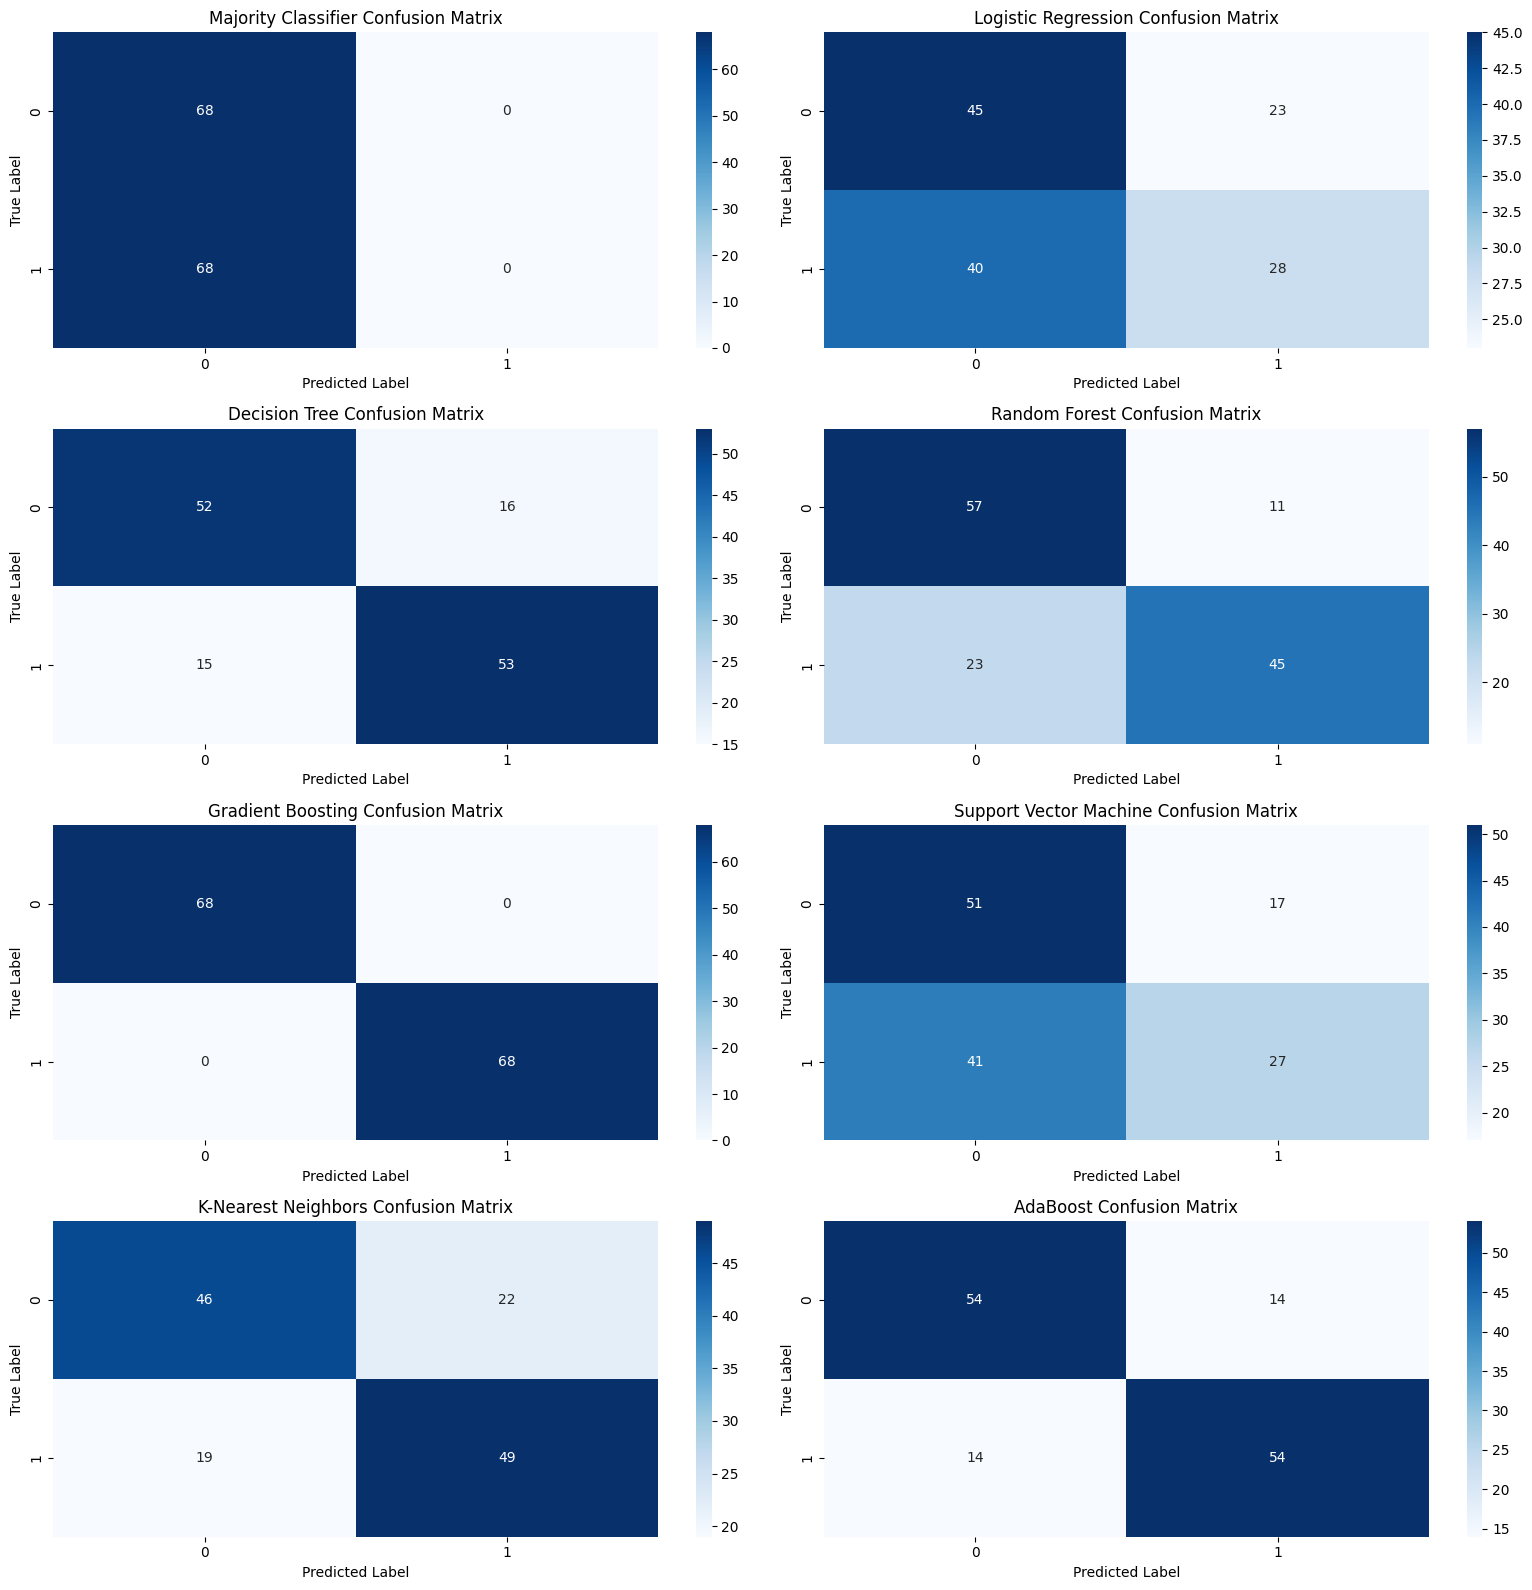

In [521]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    classification_report
)

def evaluate_models(X, y, models, cv=5):
    """
    Evaluate models using cross-validation and return comprehensive metrics
    
    Parameters:
    - X: Feature matrix
    - y: Target variable
    - models: Dictionary of tuned models
    - cv: Number of cross-validation folds
    
    Returns:
    - DataFrame with performance metrics
    """
    results = []
    
    for name, model in models.items():
        model.fit(X, y)
        # Perform cross-validation
        cv_results = cross_validate(
            model, 
            X, 
            y, 
            cv=cv, 
            scoring=['roc_auc', 'accuracy', 'precision', 'recall']
        )
        
        # Calculate mean and std of performance metrics
        results.append({
            'Model': name,
            'ROC AUC (Mean)': np.mean(cv_results['test_roc_auc']),
            'ROC AUC (Std)': np.std(cv_results['test_roc_auc']),
            'Accuracy (Mean)': np.mean(cv_results['test_accuracy']),
            'Accuracy (Std)': np.std(cv_results['test_accuracy']),
            'Precision (Mean)': np.mean(cv_results['test_precision']),
            'Precision (Std)': np.std(cv_results['test_precision']),
            'Recall (Mean)': np.mean(cv_results['test_recall']),
            'Recall (Std)': np.std(cv_results['test_recall'])
        })
    
    # Convert to DataFrame and sort by ROC AUC
    results_df = pd.DataFrame(results).sort_values('ROC AUC (Mean)', ascending=False)
    return results_df

def plot_confusion_matrices(X, y, models):
    """
    Plot confusion matrices for each model
    
    Parameters:
    - X: Feature matrix
    - y: Target variable
    - models: Dictionary of tuned models
    """
    n_models = len(models)
    fig, axes = plt.subplots(
        nrows=(n_models + 1) // 2, 
        ncols=2, 
        figsize=(16, 4 * ((n_models + 1) // 2))
    )
    axes = axes.ravel()  # Flatten axes array
    
    for i, (name, model) in enumerate(models.items()):
        # Predict using the model
        y_pred = model.predict(X)
        
        # Compute confusion matrix
        cm = confusion_matrix(y, y_pred)
        
        # Plot confusion matrix
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            ax=axes[i]
        )
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    # Remove extra subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Assume 'data' and 'target' are already defined from previous code
# If not, replace with your actual feature matrix and target variable
results_df = evaluate_models(data, target, models)
print("Cross-Validation Results:\n")
display(Markdown(results_df.to_markdown(index=False)))
# add confusion matrix
plot_confusion_matrices(data, target, models)



In [522]:
print("\nDecision Tree Analysis:")
simple_decision_tree = models['Decision Tree']
simple_decision_tree.fit(data, target)

# Create a new figure for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(simple_decision_tree, 
          filled=True, 
          feature_names=data.columns, 
          class_names=['No BDM', 'BDM'])
plt.title("Simple Decision Tree Visualization")
plt.show()

# Print feature importance ranking
importances = simple_decision_tree.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature Importance Ranking:")
for f in range(data.shape[1]):
    print(f"{f + 1}. {data.columns[indices[f]]}: {importances[indices[f]]:.3f}")


Decision Tree Analysis:


NameError: name 'plot_tree' is not defined

<Figure size 2000x1000 with 0 Axes>

<div class="alert alert-block alert-danger">
<b>FEHLT:</b>
Ton und Video als Ganzes an Das Deep Learning Model zu übergeben
</div>

## Ansatz 2 (Deep learning) ~ Spam Classification

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score


# 2. Dataset class for PyTorch
class AdDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        transcript = self.dataframe.iloc[index]["transcript"]
        label = self.dataframe.iloc[index]["BDM"]
        inputs = self.tokenizer(transcript, padding='max_length', max_length=self.max_len, truncation=True, return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 3. Tokenizer and Dataset Preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = AdDataset(ad_df, tokenizer, max_len=128)

# Split into train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# 4. Model Setup
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)

# 5. Training Loop
def train_model():
    model.train()
    for epoch in range(3):  # Training for 3 epochs
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Train the model
train_model()

# 6. Evaluation Function
def evaluate_model():
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = batch['labels'].detach().cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    print(f"Accuracy: {acc:.2f}")
    print(f"F1 Score: {f1:.2f}")
    # roc auc score
    roc_auc = roc_auc_score(true_labels, predictions)
    print(f"ROC AUC Score: {roc_auc:.2f}")

# Evaluate the model
evaluate_model()